In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import seaborn as sns

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [3]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst_new = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    '道路型態大類別名稱', '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    # '死亡受傷人數',
    # '經度', '緯度',
    # '死亡', '受傷'
]
select_lst = [
    '路面狀況-路面狀態名稱',
    # '肇因研判大類別名稱-主要', # 降低預測值
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    # '當事者區分-類別-大類別名稱-車種', # 降低預測值
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    # '路面狀況-路面鋪裝名稱', '道路障礙-視距名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他',
    # '道路障礙-障礙物名稱', '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱', '車輛撞擊部位子類別名稱-其他',
    '死亡受傷人數',
    '經度', '緯度',
]
# select_lst = [
#     '光線名稱',
#     '道路類別-第1當事者-名稱',
#     '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
#     '道路型態大類別名稱', '事故位置大類別名稱', 
#     # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
#     '死亡受傷人數',
#     '經度', '緯度',
# ]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11840) # 120420

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1)

print(full_dist.shape)
full_dist.head()

(121012, 32)


,路面狀況-路面狀態名稱,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,事故位置大類別名稱,號誌-號誌種類名稱,...,行動電話或電腦或其他相類功能裝置名稱,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,號誌-號誌動作名稱,經度,緯度,死亡,受傷
0,-0.331183,0.739901,-1.09744,-0.372169,0.146102,2.120706,-0.146069,1.210906,0.485564,-0.713755,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,0.837867,-0.634220,-1.868211,13.660843,-2.803204
1,-0.331183,0.739901,0.67326,1.175119,1.465217,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,-1.192531,1.111877,0.974928,13.660843,-0.620846
2,-0.331183,0.739901,0.67326,-0.372169,-1.173013,2.911514,-0.146069,1.210906,1.164664,-0.713755,...,-2.147278,-5.676019,-0.314290,0.508523,-0.135001,0.837867,-2.459704,-0.633180,13.660843,-2.803204
3,-0.331183,0.739901,-0.21209,-0.372169,-1.173013,-0.251720,-0.146069,-0.814068,-0.872635,2.771975,...,0.437195,0.147005,-0.314290,0.508523,-0.135001,-1.192531,0.936797,1.016777,13.660843,-0.620846
4,-0.331183,0.739901,-1.09744,-0.372169,1.465217,2.120706,-0.146069,1.210906,1.164664,-0.713755,...,-2.147278,0.147005,2.579597,0.508523,-0.135001,0.837867,1.832866,0.186897,13.660843,-2.803204


In [4]:
lens1 = PCA(10) # 10 最好
lens_result = lens1.fit_transform(X1[select_lst_new].to_numpy())

db = DBSCAN(eps=2.7, min_samples=10).fit(lens_result) # 2.7最好、最低2.2
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

n_clusters_

3

In [6]:
noise_mask = labels == -1
noise_rows = rbind_data[noise_mask]

noise_rows.shape

(43, 32)

In [7]:
# noise_rows.to_csv('CalculatedData/離群比較/原始27_V2.csv', index=False)

In [21]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始27_V2.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓樸V2.csv')[lst_logit]

print(data_origin.shape)
print(data_mapper.shape)

(43, 28)
(113, 28)


In [22]:
overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

print(non_overlapping_rows_origin.shape)
print(non_overlapping_rows_mapper.shape)
print('重複：', overlapping_rows.shape[0])

print(len(overlapping_index_origin) == len(overlapping_index_mapper))
print(overlapping_rows_origin.shape[0] == overlapping_rows_mapper.shape[0])

(5, 28)
(75, 28)
重複： 38
True
True


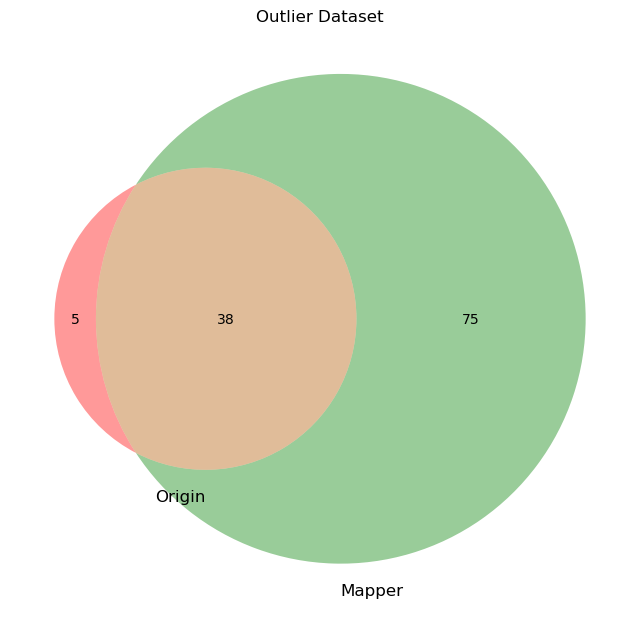

In [23]:
from matplotlib_venn import venn2 # 文氏圖

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

origin_set = set(range(total_origin))
mapper_set = set(range(total_mapper))

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('Outlier Dataset')
plt.show()

In [24]:
overlapping_rows = pd.merge(data_origin, data_mapper)
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows['type'] = 'overlap'
non_overlapping_rows_mapper['type'] = 'mapper'

data_combined = pd.concat([non_overlapping_rows_mapper, overlapping_rows], ignore_index=True)

full_dist = process_data(data_combined)
typedt = full_dist['type']

scaler = StandardScaler()
full_dist = pd.DataFrame(scaler.fit_transform(full_dist), columns = full_dist.columns)

full_dist.drop(['type'], axis=1, inplace=True)

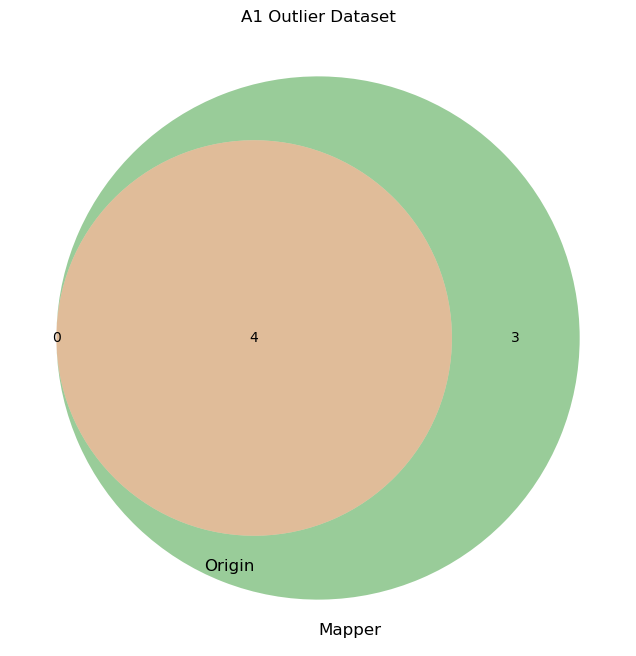

In [25]:
lst_logit = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡', '受傷'
]
data_origin = pd.read_csv('CalculatedData/離群比較/原始27_V2.csv')[lst_logit]
data_mapper = pd.read_csv('CalculatedData/離群比較/拓樸V2.csv')[lst_logit]

data_origin = data_origin[data_origin['死亡'] != 0]
data_mapper = data_mapper[data_mapper['死亡'] != 0]

overlapping_rows = pd.merge(data_origin, data_mapper)

# 使用所有列篩選，以确保完全匹配
overlapping_index_origin = data_origin[data_origin.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index
overlapping_index_mapper = data_mapper[data_mapper.apply(tuple, axis=1).isin(overlapping_rows.apply(tuple, axis=1))].index

# 提取重叠的行
overlapping_rows_origin = data_origin.loc[overlapping_index_origin]
overlapping_rows_mapper = data_mapper.loc[overlapping_index_mapper]

non_overlapping_rows_origin = data_origin.loc[~data_origin.index.isin(overlapping_index_origin)].copy()
non_overlapping_rows_mapper = data_mapper.loc[~data_mapper.index.isin(overlapping_index_mapper)].copy()

overlapping_rows_count = overlapping_rows.shape[0]
total_origin = non_overlapping_rows_origin.shape[0] + overlapping_rows_count
total_mapper = non_overlapping_rows_mapper.shape[0] + overlapping_rows_count

plt.figure(figsize=(8, 8))
venn = venn2(subsets = (non_overlapping_rows_origin.shape[0], non_overlapping_rows_mapper.shape[0], overlapping_rows_count), 
             set_labels = ('Origin', 'Mapper'))

plt.title('A1 Outlier Dataset')
plt.show()